In [1]:
from functions import *

# import functions
# from importlib import reload
# reload(functions)

Short display of the data.

In [2]:
FULL_DF = pd.read_csv("philosophy_data.csv", converters={"tokenized_sentence": pd.eval})

In [3]:
#Filter dataframe to training, test, fulldataset
train_data = 0.8
indexes = [i for i in list(FULL_DF.sample(frac=train_data).index)]
DF_TRAIN = FULL_DF.iloc[indexes]
DF_TRAIN.reset_index(drop = True, inplace = True)
DF_TEST = FULL_DF.iloc[~FULL_DF.index.isin(indexes)]
DF_TEST.reset_index(drop = True, inplace = True)

#Comment these to be able to train.
DF_TEST = FULL_DF
DF_TRAIN = FULL_DF

len(FULL_DF.index), len(DF_TEST.index), len(DF_TRAIN.index)

(308822, 308822, 308822)

In [4]:
DF_TRAIN.sample(5)

,school,author,title,tokenized_sentence,num_of_chars,num_of_words,string_sentence
303757,marxism,Karl Marx,the communist manifesto,"[ten, hours, bill, england, carried]",30,5,ten hours bill england carried
172488,plato,Plato,plato: complete works,"[bcd, statesman]",13,2,bcd statesman
147391,continental,Michel Foucault,the order of things,"[double, maybe, close, alien, role, true, unde...",354,44,double maybe close alien role true undertaking...
129461,capitalism,David Ricardo,on the principles of political economy and tax...,"[adam, smith, constantly, magnifies, advantage...",94,13,adam smith constantly magnifies advantages cou...
194052,plato,Plato,plato: complete works,"[nowadays, reasonable, guess, fact, done, time]",40,6,nowadays reasonable guess fact done time


Extract the tokenized_sentence DF["tokenized_sentence"] sentences and append them into a python list.

Load w2v model, Skip-gram, CBOW

In [5]:
skipgram_w2v = Word2Vec(
            DF_TRAIN["tokenized_sentence"].tolist(),
            vector_size=300,       # Dimensionality of word embeddings
            sg = 1,                # SKIPGRAM
            window=5,              # Word window for context evaluation
            epochs=10)             # Number of epochs training over corpus

cbow_w2v = Word2Vec(
            DF_TRAIN["tokenized_sentence"].tolist(),
            vector_size=300,
            sg = 0,                # CBOW
            window=5,
            epochs=10)

len(skipgram_w2v.wv), len(cbow_w2v.wv)

(26653, 26653)

The sentence_vectorizer function summarizes each vectorized word in a sentence and divides the sum with the amount of words in the sentence.
Doing this will allow us to get whole sentences vectorized values instead of individual words.
Using the function with our model (in this case w2v) sentences.
Can also be used with pretrained models.

In [6]:
DF_TEST, skipgram_sentences = vectorize_sentences(skipgram_w2v.wv, DF_TEST)
DF_TEST, cbow_sentences = vectorize_sentences(cbow_w2v.wv, DF_TEST)

#Should be equal
len(DF_TEST["tokenized_sentence"]), len(skipgram_sentences), len(cbow_sentences)

(307742, 307742, 307742)

Fetch the number of unique School of Thoughts.

In [7]:
unique_schools = DF_TEST["school"].unique().tolist()
print(unique_schools)
num_clusters = len(unique_schools)

['rationalism', 'analytic', 'empiricism', 'phenomenology', 'capitalism', 'continental', 'plato', 'aristotle', 'german_idealism', 'marxism']


Bar plot how many sentences are from each School of Thought.
(Show the total amount of real assigned SOT on each text.)

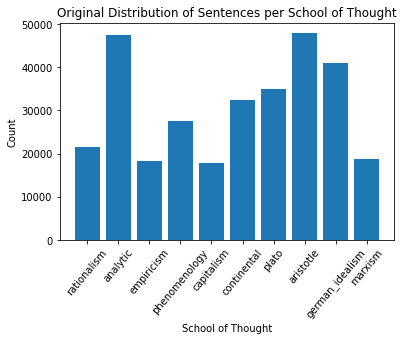

In [8]:
total_dict = dict.fromkeys(unique_schools, 0)
for school in DF_TEST["school"]:
    total_dict[school] += 1

plt.bar(range(len(total_dict)), total_dict.values(), align='center')
plt.xticks(range(len(total_dict)), total_dict.keys())
plt.xticks(rotation=50)
plt.xlabel("School of Thought")
plt.ylabel("Count")
plt.title("Original Distribution of Sentences per School of Thought")
plt.show()

Apply kmeans with num_clusters=amount of unique schools in the DF.

In [9]:
start = time.time()

#Skip-gram and cbow.
skipgram_w2v_kmeans, skipgram_w2v_labels, skipgram_w2v_centroids = apply_kmeans(num_clusters, skipgram_sentences)
cbow_w2v_kmeans, cbow_w2v_labels, cbow_w2v_centroids = apply_kmeans(num_clusters, cbow_sentences)

end = time.time()
print(end - start)

456.07519793510437


Apply scatter plot on kmeans results using TSNE.
Scatter plot using TSNE, PCA and UMAP

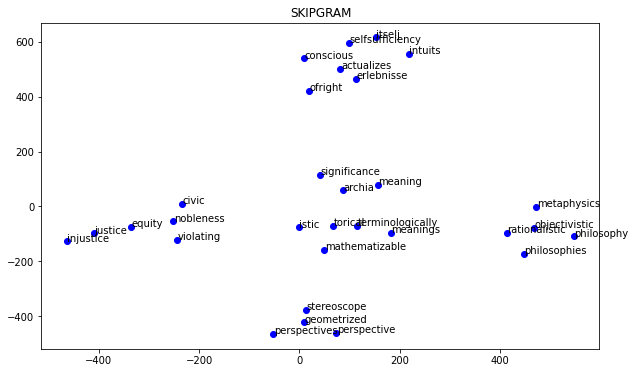

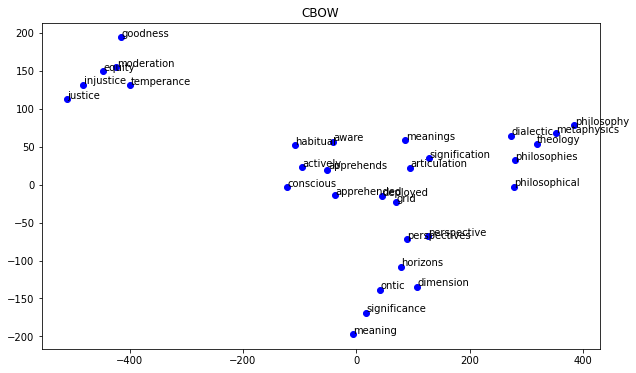

In [10]:
# scatter_plot(type='pca', labels=skipgram_w2v_labels, values=skipgram_sentences)
# scatter_plot(type='pca', labels=cbow_w2v_labels, values=cbow_sentences)

words = ['meaning', 'philosophy', 'justice', 'conscious', 'perspective']
plot_similar_words(skipgram_w2v.wv, words, title="SKIPGRAM",top_words=5)
plot_similar_words(cbow_w2v.wv, words,title="CBOW", top_words=5)

Combine the kmeans clustering results with the labels.
Put the kmeans result in a dictionary:

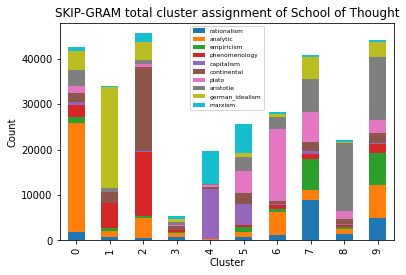

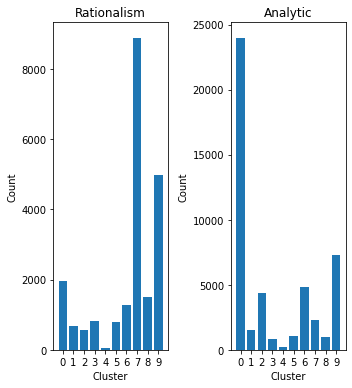

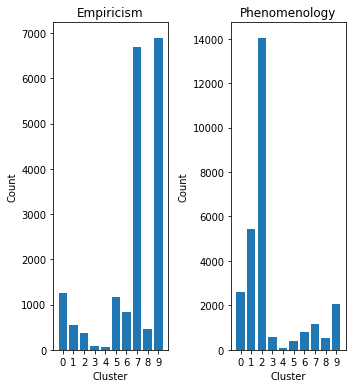

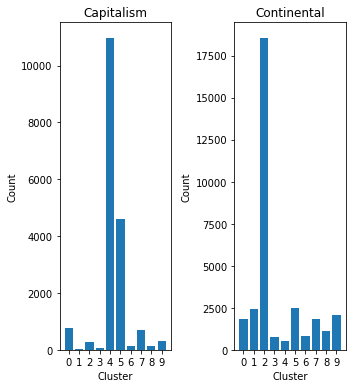

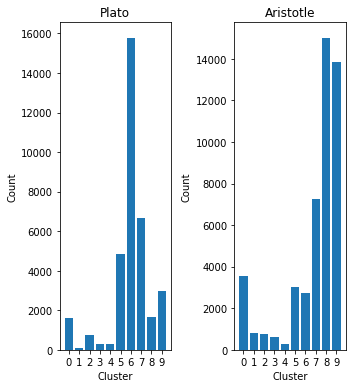

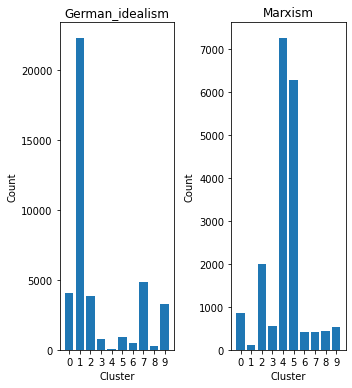

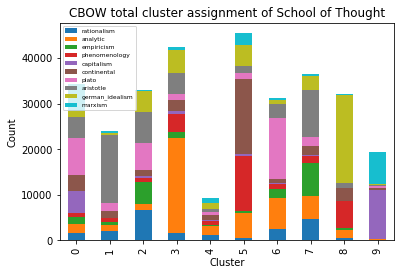

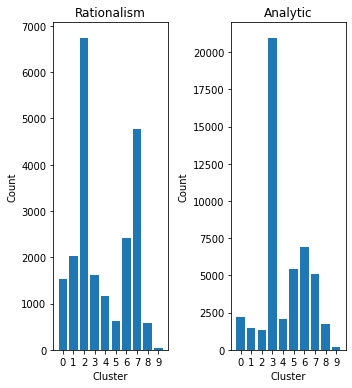

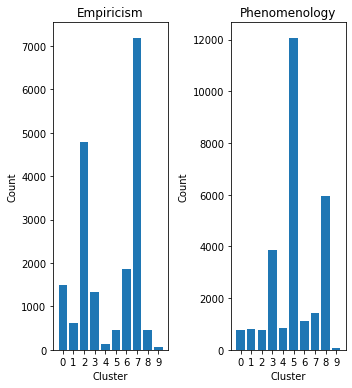

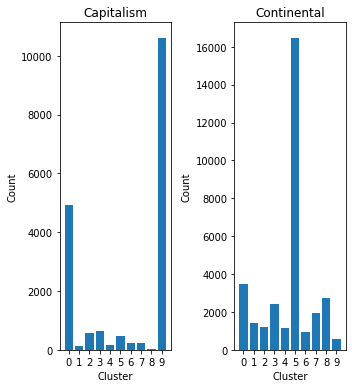

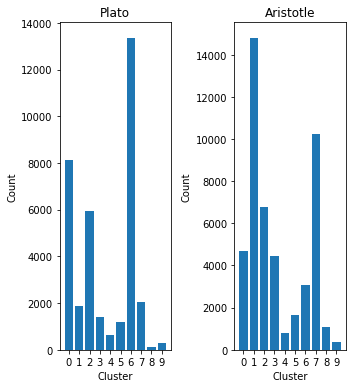

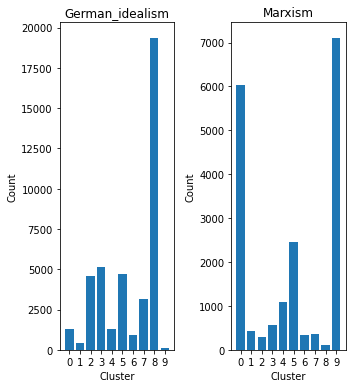

In [11]:
#How many times cluster n was assigned to specific SOT
cluster_n_assigned(DF=DF_TEST, labels=skipgram_w2v_labels, schools=unique_schools, name='skip-gram')
cluster_n_assigned(DF=DF_TEST, labels=cbow_w2v_labels, schools=unique_schools, name='cbow')

Make a list and convert all "plato" to 0 and "aristotle" to 1, etc.
This can then be applied with the predicted labels with v_measure.

In [12]:
original_labels = [unique_schools.index(school) for school in DF_TEST["school"]]

Apply v-measure.

In [13]:
#w2v
skipgram_v_measure = v_measure_score(original_labels, skipgram_w2v_labels)
cbow_v_measure = v_measure_score(original_labels, cbow_w2v_labels)

skipgram_v_measure, cbow_v_measure

(0.27906928780550294, 0.2348378005045245)

In [14]:
words = ['thinking', 'teaching', 'justice', 'conscious', 'perspective']

In [15]:
most_similar_skip_gram = {word: [word_tuple for word_tuple in skipgram_w2v.wv.most_similar([word], topn=5)] for word in words}
pd.DataFrame.from_dict(most_similar_skip_gram, orient='index',
                       columns=[i for i in range(1,6)])

,1,2,3,4,5
thinking,"(intuiting, 0.4987061023712158)","(griffin, 0.4730592668056488)","(genitality, 0.46848830580711365)","(wishful, 0.46610721945762634)","(intuits, 0.4572002589702606)"
teaching,"(bedside, 0.5334247350692749)","(practising, 0.5157573819160461)","(harvard, 0.4942875802516937)","(pupils, 0.4925541281700134)","(lessons, 0.48687365651130676)"
justice,"(injustice, 0.6365818977355957)","(equity, 0.5497300028800964)","(civic, 0.5121265649795532)","(violating, 0.5089267492294312)","(nobleness, 0.4979414641857147)"
conscious,"(intuits, 0.5564935207366943)","(actualizes, 0.5472513437271118)","(selfsufficiency, 0.5407580137252808)","(erlebnisse, 0.5309363007545471)","(itselj, 0.5308520197868347)"
perspective,"(geometrized, 0.5120425224304199)","(stereoscope, 0.49815425276756287)","(mathematizable, 0.49052512645721436)","(perspectives, 0.48771557211875916)","(istic, 0.4798998236656189)"


In [16]:
most_similar_cbow = {word: [word_tuple for word_tuple in cbow_w2v.wv.most_similar([word], topn=5)] for word in words}
pd.DataFrame.from_dict(most_similar_cbow, orient='index',
                       columns=[i for i in range(1,6)])

,1,2,3,4,5
thinking,"(intuiting, 0.5801904201507568)","(thought, 0.529145359992981)","(perceiving, 0.5100758075714111)","(wishful, 0.48069262504577637)","(thei, 0.4788713753223419)"
teaching,"(instruction, 0.7113298177719116)","(students, 0.7058207392692566)","(practise, 0.6694450974464417)","(learned, 0.6636719703674316)","(teach, 0.6568168997764587)"
justice,"(equity, 0.69671231508255)","(injustice, 0.689963161945343)","(temperance, 0.618942379951477)","(moderation, 0.5989204049110413)","(goodness, 0.5723484754562378)"
conscious,"(actively, 0.6409295201301575)","(aware, 0.5860797166824341)","(habitual, 0.5615730881690979)","(apprehends, 0.5544518232345581)","(apprehended, 0.5410025715827942)"
perspective,"(perspectives, 0.6510258316993713)","(deployed, 0.5985205173492432)","(horizons, 0.5957556366920471)","(grid, 0.592500627040863)","(dimension, 0.5860675573348999)"


Calculate the best v_measure.
Apply different values for window/vector_size/iterations.
vector_size: 50 -> 100 -> 300
window: 2 -> 3 -> 5 -> 7

Saving the V-max in the dataframes.

In [17]:
#If want to train models on full corpus
train = False
#Iterations
epochs = 10
vector_size = 50
iterations = 10

v_measure_list_skipgram_2 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_2 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_3 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=3, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_3 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=3, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train, train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_7 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=7, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_7 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=7, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

Average Time per Iteration: 95.39007232189178
Average Time per Iteration: 72.06670472621917
Average Time per Iteration: 134.72879076004028
Average Time per Iteration: 93.2208604812622
Average Time per Iteration: 130.6428293943405
Average Time per Iteration: 70.0216828584671
Average Time per Iteration: 137.82523002624512
Average Time per Iteration: 100.15551526546479


In [18]:
v_measure_dict_50 = {"skipgram_2": v_measure_list_skipgram_2,
                        "skipgram_3": v_measure_list_skipgram_3,
                        "skipgram_5": v_measure_list_skipgram_5,
                        "skipgram_7": v_measure_list_skipgram_7,
                        "cbow_2": v_measure_list_cbow_2,
                        "cbow_3": v_measure_list_cbow_3,
                        "cbow_5": v_measure_list_cbow_5,
                        "cbow_7": v_measure_list_cbow_7}

# 50 Vec Size
v_measure_plot_dict_50 = {"Window_2": [max(v_measure_list_skipgram_2), max(v_measure_list_cbow_2)],
                           "Window_3": [max(v_measure_list_skipgram_3), max(v_measure_list_cbow_3)],
                           "Window_5": [max(v_measure_list_skipgram_5), max(v_measure_list_cbow_5)],
                           "Window_7": [max(v_measure_list_skipgram_7), max(v_measure_list_cbow_7)]}

df_v_measure_50 = pd.DataFrame.from_dict(v_measure_plot_dict_50, orient='index',
                       columns=["Skip-gram", "CBOW"])

df_v_measure_50.style.set_caption("Overview of V-measure results")

,Skip-gram,CBOW
Window_2,0.256013,0.225546
Window_3,0.264121,0.229643
Window_5,0.273688,0.233414
Window_7,0.275517,0.237074


In [19]:
#If want to train models on full corpus
train = False
#Iterations
epochs = 10
vector_size = 100
iterations = 10

v_measure_list_skipgram_2 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_2 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_3 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=3, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_3 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=3, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train, train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_7 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=7, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_7 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=7, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

Average Time per Iteration: 214.81064298152924
Average Time per Iteration: 173.16036348342897
Average Time per Iteration: 184.23786759376526
Average Time per Iteration: 140.94981689453124
Average Time per Iteration: 162.57374942302704
Average Time per Iteration: 95.22284288406372
Average Time per Iteration: 170.97587525844574
Average Time per Iteration: 100.80095915794372


In [20]:
v_measure_dict_100 = {"skipgram_2": v_measure_list_skipgram_2,
                        "skipgram_3": v_measure_list_skipgram_3,
                        "skipgram_5": v_measure_list_skipgram_5,
                        "skipgram_7": v_measure_list_skipgram_7,
                        "cbow_2": v_measure_list_cbow_2,
                        "cbow_3": v_measure_list_cbow_3,
                        "cbow_5": v_measure_list_cbow_5,
                        "cbow_7": v_measure_list_cbow_7}

# 100 Vec Size
v_measure_plot_dict_100 = {"Window_2": [max(v_measure_list_skipgram_2), max(v_measure_list_cbow_2)],
                           "Window_3": [max(v_measure_list_skipgram_3), max(v_measure_list_cbow_3)],
                           "Window_5": [max(v_measure_list_skipgram_5), max(v_measure_list_cbow_5)],
                           "Window_7": [max(v_measure_list_skipgram_7), max(v_measure_list_cbow_7)]}

df_v_measure_100 = pd.DataFrame.from_dict(v_measure_plot_dict_100, orient='index',
                       columns=["Skip-gram", "CBOW"])

df_v_measure_100.style.set_caption("Overview of V-measure results")

,Skip-gram,CBOW
Window_2,0.261491,0.228134
Window_3,0.269476,0.231152
Window_5,0.277247,0.235625
Window_7,0.279468,0.237509


In [21]:
#If want to train models on full corpus
train = False
#Iterations
epochs = 10
vector_size = 300
iterations = 10

v_measure_list_skipgram_2 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_2 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_3 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=3, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_3 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=3, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train, train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_7 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=7, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_7 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=7, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

Average Time per Iteration: 250.17412421703338
Average Time per Iteration: 291.8417087554932
Average Time per Iteration: 379.3452088832855
Average Time per Iteration: 250.63587653636932
Average Time per Iteration: 457.3528725385666
Average Time per Iteration: 261.2950889348984
Average Time per Iteration: 348.55465588569643
Average Time per Iteration: 232.02258598804474


In [22]:
v_measure_dict_300 = {"skipgram_2": v_measure_list_skipgram_2,
                   "skipgram_3": v_measure_list_skipgram_3,
                   "skipgram_5": v_measure_list_skipgram_5,
                   "skipgram_7": v_measure_list_skipgram_7,
                   "cbow_2": v_measure_list_cbow_2,
                   "cbow_3": v_measure_list_cbow_3,
                   "cbow_5": v_measure_list_cbow_5,
                   "cbow_7": v_measure_list_cbow_7}

# 300 Vec Size
v_measure_plot_dict_300 = {"Window_2": [max(v_measure_list_skipgram_2), max(v_measure_list_cbow_2)],
                           "Window_3": [max(v_measure_list_skipgram_3), max(v_measure_list_cbow_3)],
                           "Window_5": [max(v_measure_list_skipgram_5), max(v_measure_list_cbow_5)],
                           "Window_7": [max(v_measure_list_skipgram_7), max(v_measure_list_cbow_7)]}

df_v_measure_300 = pd.DataFrame.from_dict(v_measure_plot_dict_300, orient='index',
                       columns=["Skip-gram", "CBOW"])

df_v_measure_300.style.set_caption("Overview of V-measure results")

,Skip-gram,CBOW
Window_2,0.265005,0.229204
Window_3,0.272295,0.232029
Window_5,0.279887,0.235751
Window_7,0.283386,0.237760
